# Geostatistics

## 2. Univariate statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy import sqrt
from bokeh.plotting import figure, output_notebook, show
from bokeh.models.tools import HoverTool
from bokeh.layouts import row
from bokeh.transform import linear_cmap

output_notebook()

Loading BokehJS ...

### 2.1 Why statistics?

Usually we do not know all possible system states. And even if, it would be hard to describe *system behavior* while taking all states into consideration. Thus, we usually try to describe a *common* state, or a representative one.

This already implies that the question of how to describe a system using means of statistics is already bound to the context. It is important **why** we want to describe that system.

Let's load one of the data sets of the last lecture:

In [2]:
df = pd.read_csv('./data/sample_data.txt', sep='\s+')
data = df.iloc[:,1].values

In [3]:
print(data[:5], '...', data[:5])

[-0.16441089  0.03598559 -0.18827199  0.36503706 -0.02894305] ... [-0.16441089  0.03598559 -0.18827199  0.36503706 -0.02894305]


#### Expected Value

First, we can describe the **distribution** of observations by their **mean** value. In statistics, this is often referred to as the **expected value**.

$$ \mu = \frac{\sum}{N} $$

In [4]:
sum(data) / len(data)

0.7583277269546096

But does ``0.76`` (approx.) really describe the other values?

How many of them are off by only ``0.1``?

In [5]:
mu = sum(data) / len(data)
close = sum([abs(x - mu) < 0.1 for x in data])
print('%d of %d values are closer than 0.1' % (close, len(data)))

43 of 500 values are closer than 0.1


#### Variance

What we did in the last slide was trying to estimate a measure for the dispersion of the distribution. The more systematic way to do so is calculating the **variance**.

$$ s^2 = \frac{\sum_{i=0}^N (\mu - x_i)^2}{N} $$

In [6]:
v = sum((data - mu)**2) / len(data)
print('The variance is %.2f' % v)

The variance is 0.78


#### Standard deviation

The value $s$ used to calculate the *variance* $s^2$ is also called **standard deviation**. When we set the threshold to ``0.1`` earlier to get an idea of how many observations are close to the mean value, we also could have used the standard deviation. It is an important measure for the spread of a distribution.

In [7]:
sqrt(v)

0.8815188576246978

#### Covariance

The covariance is a measure of low and high values of two samples are related to each other. It tells us how two samples are *related* to each other. It's defined as the expected value of the deviation product of both samples. The Covariance is an important measure in geostatistics and it comes with some assumptions:

* two samples origin from the same probability distribution
* relates the samples *monotonically*

For each sample we can calculate the deviation of each observation from the samples' location:

$$ S_X =  x_i - \mu_X $$

The covariance is the then the expected value of the product of $S_X$ and $S_Y$.
Which can be written as:

$$Cov(X, Y) = \frac{\sum_i^N [(x_i - \mu_X) * (y_i - \mu_Y)]}{N}$$

In [8]:
# get the samples - you can change the numbers
X = df.iloc[:, 14].values
Y = df.iloc[:, 10].values

# sample means
mX = sum(X) / len(X)
mY = sum(Y) / len(Y)

cov = sum([(x - mX) * (y - mY) for x,y in zip(X, Y)]) / len(X)

print('Cov(X,Y) = ', cov)

Cov(X,Y) =  0.19403510392660436


*place the comparison plot of all samples here (heatmap)*

### 2.2 Sample size

All the statistical moments shown above are *sample statistics*. They are no features of the underlying population. That means, they are all influenced by sample size.

In [9]:
# sample experiment
n = 150
np.random.seed(42)
random_index = np.random.choice(range(len(data)), replace=False, size=len(data))
def get_stats(i):
    d = data[random_index[:i]]
    return dict(mu=np.mean(d), var=np.var(d), err=sqrt(np.var(d)))
samples = {i:get_stats(i) for i in range(10,n)}

# plot
def plt_samples():
    fig, ax = plt.subplots(1, 1, figsize=(14,6))
    pd.DataFrame(samples).T.plot(ax=ax)
    ax.hlines(np.mean(data), xmin=10, xmax=n, color='blue', linestyle='--', alpha=.5)
    ax.hlines(np.var(data), xmin=10, xmax=n, color='orange', linestyle='--', alpha=.5)
    ax.hlines(np.sqrt(np.var(data)), xmin=10, xmax=n, color='green', linestyle='--', alpha=.5)

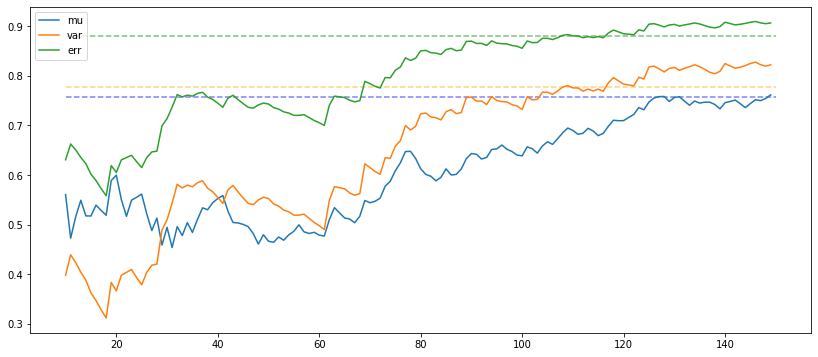

In [10]:
plt_samples()

### 2.3 Sample statistics

Sample statisitcs are **estimations** of the population. 

Estimations are **uncertain**.

In [127]:
from bokeh.palettes import Cividis256 as palette
sample = lambda n: np.mean(np.random.choice(data, size=n, replace=False))

cm = linear_cmap(np.arange(10,250,1), palette, 10, 250)
resample = figure(width=700, height=400, y_range=(0,300), tools=[])


for i in reversed([1, 10, 100, 1000, 5000]):
    if i >= 1000:
        y = np.random.randint(10,250,size = i)
        x = [sample(_ if _ < 450 else 450) for _ in y]
    elif i == 1:
        np.random.seed(42)
        x = [sample(10)]
        y = [10]
    else:
        y = np.random.randint(10,80,size = i)
        x = [sample(n) for _ in y]
        
        
    if i > 1:
        r = resample.scatter(
            x, y, 
            fill_color={'field': 'y','transform': cm['transform']}, 
            line_color=None if i >= 1000 else 'white', legend_label='Draw %d' % i,
            size= 8 if i < 1000 else 4
        )
        r.visible = False
    else:
        resample.scatter(x,y,fill_color='darkred', line_color='white', legend_label='Single experiment', size=10)

resample.xaxis.axis_label = 'Sample mean'
resample.yaxis.axis_label = 'Sample Size'
resample.legend.click_policy = 'hide'
resample.legend.location = 'top_center'
resample.legend.orientation = 'horizontal'

In [128]:
show(resample)

### 2.4 Visualizing distributions

Knowing about the first two moments of a distribution is nice, but does not tell everything about a distribution. We can visualize how the observation values are distributed using a **histogram**. For this, we group the values into classes and count the number of occurences in each class. This process is called **binning**. There are tons of publications about binning.

In [10]:
count, edges = np.histogram(data, bins=50)

histogram = figure(tools=[], toolbar_location="above")
histogram.quad(top=count, bottom=0, left=edges[:-1], right=edges[1:], fill_color="navy", line_color="white", alpha=.5)
histogram.y_range.start = 0

hover = HoverTool(tooltips=[('Value range:', '@left to @right'), ('Count', '@top')])
histogram.add_tools(hover)

In [11]:
show(histogram)

A histogram is nevertheless a visalization of the **sample**, not the population.

#### Sample Size

Like for the first and second statistical moment, the histogram is also majorly influenced by the sample size.

In [12]:
np.random.seed(42)
random_index = np.random.choice(range(len(data)), replace=False, size=len(data))

hist = figure(tools=[], toolbar_location="above", width=450, height=450)

for n, color in zip((30,50,100,150,200), ('navy', 'purple', 'orange', 'red', 'darkred')):
    d = data[random_index[:n]]
    c, e = np.histogram(d, bins=25, density=True)
        
    r = hist.quad(top=c, bottom=0, left=e[:-1], right=e[1:], fill_color=color, line_color="white",
             legend_label='N=%d' % n, alpha=.5)
    if n != 30:
        r.visible = False

hist.legend.location = 'top_right'
hist.legend.click_policy = 'hide'

In [13]:
show(hist)

#### KDE

Another approach to visualize a distribution is a **k**ernel **d**ensity **e**stimation. 

The main difference is that each observation is shown in the graph, representated by a simple geometry, for example a sqaure. These shapes then recieve a size, often called *bandwidth* in the graph, which has to be defined. Overlapping shapes are just added **onto** each other. A very common method is:

Gaussian KDE where:

* each observation is represented by a gaussian *kernel* like $\frac{1}{2\pi}exp(-\frac{1}{2}h^2)$
* overlapping kernels are added onto each other

In [14]:
from scipy.stats import gaussian_kde

kf = gaussian_kde(data)

x = np.linspace(1.2* data.min(), 1.2*data.max(), 100)
y = kf(x) * data.max()

kde = figure(tools=[], height=450, width=600)
kde.patch(x, y, line_color='black', color='navy', alpha=0.3)

GlyphRenderer(id='1329', ...)

In [15]:
show(kde)

### 2.5 Comparing distributions

Something that we commonly need to do, is compare two distributions. Typical questions we want to solve that way are:

* Are two samples from the same population?

* If we observe different processes in the environment, can we *see* these differences in statistical properties?

* Can we correlate difference in statistical properties to system properties?

#### How to compare

From what we have seen above, we can of course use a histogram or KDE to compare two distributions visually.

The other possibility is to compare the statistical moments. There are statistical tests to do so.

We can load some more samples, which were also collected from the same population:

In [16]:
sample1 = data.copy()
sample2 = df.iloc[:,13].values
sample3 = df.iloc[:,14].values

sample_moments = pd.DataFrame(dict(
    sample1=dict(mean=np.mean(sample1), var=np.var(sample1), min=np.min(sample1), max=np.max(sample1)),
    sample2=dict(mean=np.mean(sample2), var=np.var(sample2), min=np.min(sample2), max=np.max(sample2)),
    sample3=dict(mean=np.mean(sample3), var=np.var(sample3), min=np.min(sample3), max=np.max(sample3))
))

In [17]:
sample_moments

,sample1,sample2,sample3
mean,0.758328,0.703931,0.488372
var,0.777075,0.784418,0.685805
min,-1.274929,-1.290128,-1.906964
max,2.784031,2.582916,2.560545


The mean of sample 1 and 2 looks similar, even if not the same. This also applies to the variance. 

But what about sample 3? 

In [18]:
# calculate the bins
bins = np.linspace(df.min().min(), df.max().max(), 50)
hover = HoverTool(tooltips=[('Value range:', '@left to @right'), ('Count', '@top')])
figs = []

for sample in (sample1, sample2, sample3):
    c, e = np.histogram(sample, bins=bins)
    f  = figure(tools=[], toolbar_location="above", width=250, height=250)
    f.quad(top=c, bottom=0, left=e[:-1], right=e[1:], fill_color="navy", line_color="white", alpha=.5)
    f.y_range.start = 0
    f.add_tools(hover)
    figs.append(f)

In [19]:
show(row(figs))

It looks like the three samples have different modes, although drawn from the same population.

#### Statistical testing

We can test the three samples for their mean values. There is the:

* **T-Test**, that can test a single sample for a specific mean, 
* **Two-sided T-Test** that can be used to compare two samples for mean equality and
* **paired T-Test** for comparing two dependent samples

Each test works by defining a **null hypothesis** that assumes means to be non-different. Then, we calculate a **test statistic value** that is associated with a probability. If this probability is lower than a **confidence level**, we have to **reject** the null hypothesis in favor of a alternative hypothesis.

**Null hypothesis**:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\mu_{sample1} = \mu_{sample2}$

**Alternative hypothesis**:&nbsp;&nbsp;&nbsp;$\mu_{sample1} \neq \mu_{sample2}$

**Confidence level**:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$0.05$

In [20]:
print('Sample 1 - Sample 2 p-value:     %.3f' % stats.ttest_ind(sample1, sample2).pvalue)
print('Sample 2 - Sample 3 p-value:     %g' % stats.ttest_ind(sample2, sample3).pvalue)

Sample 1 - Sample 2 p-value:     0.331
Sample 2 - Sample 3 p-value:     7.66348e-05


Thus, we can conclude, that for sample 1 and 2 the null hypothesis holds, while for 2 and 3 we have to **reject** it.

One reason might be, that we treated the samples as a univariate dataset with independent observations. In fact, the data has an **order**. This becomes obvious if we plot the obersavtions in order of occurence:

In [21]:
series = figure(tools=[], width=700, height=350)
series.line(range(500), sample1, legend_label='Sample 1', color='green')
series.line(range(500), sample2, legend_label='Sample 2', color='orange')
series.line(range(500), sample3, legend_label='Sample 3', color='darkblue')
series.legend.click_policy = 'hide'
series.legend.location = 'bottom_left'
series.legend.orientation = 'horizontal'

In [22]:
show(series)

It is quite obvious, that the samples are **multivariate** and the value on the y-axis **depends** on the x-axis value. 
The x-axis could i.e. show **time** (time series) or **distance** (transect). 